# Gold recovery prediction

The data is stored in three files:

gold_recovery_train.csv — training dataset download  
gold_recovery_test.csv — test dataset download  
gold_recovery_full.csv — source dataset download  

Data is indexed with the date and time of acquisition (date feature). Parameters that are next to each other in terms of time are often similar. Some parameters are not available because they were measured and/or calculated much later. That's why, some of the features that are present in the training set may be absent from the test set. The test set also doesn't contain targets. The source dataset contains the training and test sets with all the features. You have the raw data that was only downloaded from the warehouse. 

Description of the data
- rougher.output.recovery - Output of the rougher
- rougher.output.tail_ag - Concentration of Silver
- rougher.output.tail_sol - Concentration of solution
- rougher.output.tail_au - Concentration of Gold
- rougher.input.floatbank11_xanthate - Floatation bank input
- secondary_cleaner.output.tail_sol - Secondary stage cleaner concentrate
- final.output.recovery - Final output
- rougher.calculation.au_pb_ratio - Gold to Lead ratio
- primary_cleaner.input.sulfate - Concentrate of sulphate
- primary_cleaner.input.depressant - Concentrate of depressant

Answer these questions:
1. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
2. Analyze the features not available in the test set. What are these parameters? What is their type?
3. Perform data preprocessing.
4. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
5. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
6. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.
7. Write a function to calculate the final sMAPE value.
8. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

## Data preparation

### Open the files and take a look at the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Import data

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col='date', parse_dates=True)
data_test =  pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col='date', parse_dates=True)
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col='date', parse_dates=True)

Check sample sizes

In [3]:
print('Обучающая выборка', data_train.shape)
print('Тестовая выборка', data_test.shape)
print('Общая выборка', data_full.shape)

Обучающая выборка (14149, 86)
Тестовая выборка (5290, 52)
Общая выборка (19439, 86)


In [4]:
print('------------------Обучающая выборка--------------------')
display(data_train.head())
print('------------------Тестовая выборка--------------------')
display(data_test.head())
print('------------------Общая выборка--------------------')
display(data_full.head())

------------------Обучающая выборка--------------------


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


------------------Тестовая выборка--------------------


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


------------------Общая выборка--------------------


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Check columns and datatypes.

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant                      14117 non-null float64
primary_c

In [6]:
data_train.isnull().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
                                            ... 
rougher.output.tail_pb                         0
rougher.input.feed_au                          0
rougher.output.recovery                        0
rougher.output.concentrate_au                  0
secondary_cleaner.output.tail_au               0
Length: 86, dtype: int64

In [7]:
data_train.duplicated().sum()

0

The training dataset contains 86 columns with data on final.output, primary_cleaner, rougher.output, secondary_cleaner (the main stages of ore purification). The data contains gaps in some columns, the data does not contain duplicates.

In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                    

In [9]:
data_test.duplicated().sum()

0

The test dataset contains 52 columns (less than in the training data). There are no duplicates in the data, there are columns with missing values.

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant                      19402 non-null float64
primary_c

In [11]:
data_full.duplicated().sum()

0

In [12]:
data_full.isnull().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
                                            ... 
rougher.output.tail_pb                         0
rougher.input.feed_au                          0
rougher.output.recovery                        0
rougher.output.concentrate_au                  0
rougher.state.floatbank10_f_level              0
Length: 86, dtype: int64

There are 86 columns, missing values and no duplicates in the source dataset.

### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

The recovery is calculted as


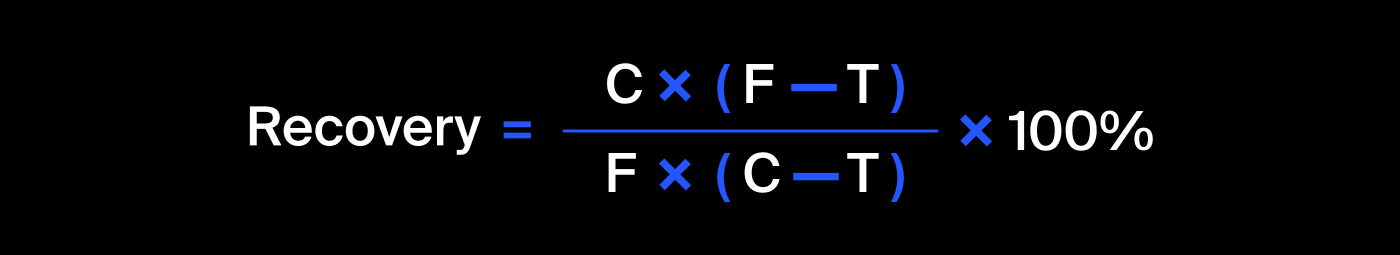

where:

C — share of gold in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)  
F — share of gold in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)  
T — share of gold in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)  

In [13]:
c = data_train['rougher.output.concentrate_au']
f = data_train['rougher.input.feed_au']
t = data_train['rougher.output.tail_au']

data_train['recovery_calculated'] = (c * (f - t)) / ( f* (c - t)) * 100

In [14]:
print(mean_absolute_error(data_train['rougher.output.recovery'].fillna(0), data_train['recovery_calculated'].fillna(0)))

9.682896147825551e-15


MAE tends to zero, the initial data is correct.

### Analyze the features that are not available in the test sample. What are these parameters? What are their data types?


In [15]:
columns_not_in_test = []
for i in data_train.columns:
    if i not in(data_test.columns):
        columns_not_in_test.append(i)

columns_not_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

As we can see, the test dataset lacks columns with data on outputs at different stages of purification, as well as calculated flotation parameters (not available at this stage).

### Perform data preprocessing

Since, according to the process, the parameters adjacent in time are often similar, we will use the fill method to fill in the gaps in the data sets

In [16]:
data_train  = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')
data_full = data_full.fillna(method='ffill')

display(data_train.isnull().sum().sum()) 
display(data_test.isnull().sum().sum())
display(data_full.isnull().sum().sum())


0

0

0

Add target features to the test sample.

In [17]:
data_test = data_test.merge(data_full[['rougher.output.recovery', 'final.output.recovery']], 
                           how = 'left', on = 'date')

data_test.shape

(5290, 54)

To build models, we will leave the same characteristics in the training sample as in the test sample.

In [18]:
data_train_new = data_train[data_test.columns].copy()

data_train_new.shape

(14149, 54)

### Conclusion

On the data preparation stage:
+ data was loaded and verified, missing values were detected, no duplicates were found, it was found that the test sample contains fewer features than the training one
+ it was verified that the ore dressing efficiency is calculated correctly
+ the parameters missing in the test sample were checked
+ data preprocessing was carried out: the missing values were filled in, the columns in the training sample were aligned with the columns of the test sample

## Data analysis

### Check how the concentration of metals (Au, Ag, Pb) changes at different stages of purification. Describe the conclusions.

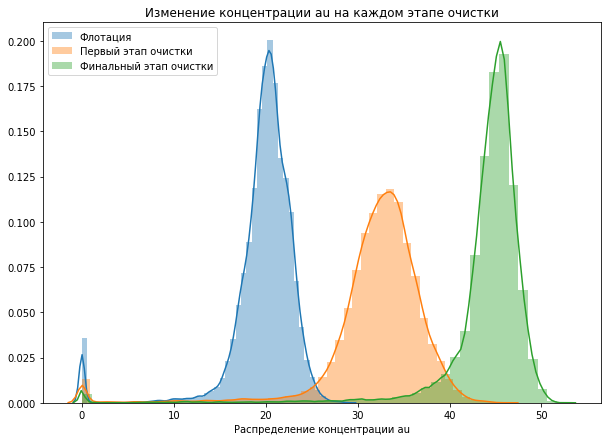

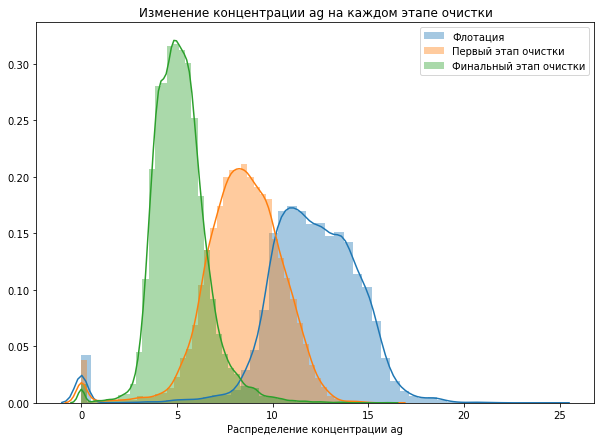

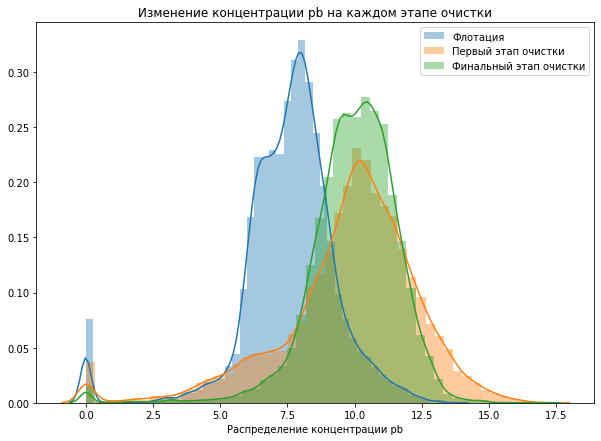

In [19]:
elements = ['au', 'ag', 'pb']
stages = [('rougher.output.concentrate_', 'Флотация'), 
          ('primary_cleaner.output.concentrate_', 'Первый этап очистки'), 
          ('final.output.concentrate_', 'Финальный этап очистки')]

for element in elements:
    plt.figure(figsize=(10,7))
    for stage in stages:
        ax = sns.distplot(data_full[stage[0] + element], label=stage[1])
        plt.legend()
        plt.xlabel('Распределение концeнтрации ' + element)
        plt.title('Изменение концентрации ' + element + ' на каждом этапе очистки')
    plt.show()

The concentration of gold increases with each stage of purification, while the concentration of silver decreases, and the concentration of lead remains approximately at the same level after the first stage of purification.
The data contains zero values of metal content, most likely, these are outliers in the data.

### Compare the distributions of raw material pellets size in the training and test samples. If the distributions are very different from each other, the model prediction will be incorrect.

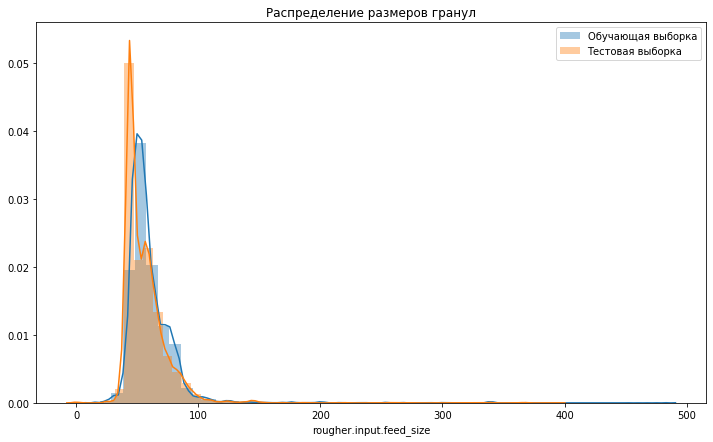

In [20]:
plt.figure(figsize=(12,7))
sns.distplot(data_train_new['rougher.input.feed_size'],  label='Обучающая выборка')
sns.distplot(data_test['rougher.input.feed_size'],label='Тестовая выборка')
plt.title('Распределение размеров гранул')
plt.legend()
plt.show()

The distributions of raw material pellet sizes in the training and test samples are similar, with just a slight differences which are within the range of acceptable values.

### Срусл the total concentration of all substances at different stages: in raw materials, in rough and final concentrates.

Add columns with the total concentration of substances to the dataset.

In [21]:
data_full['rougher.input.concentrate_total'] = data_full[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']].T.sum()

data_full['rougher.output.concentrate_total'] = data_full[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].T.sum()

data_full['final.output.concentrate_total'] = data_full[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].T.sum()

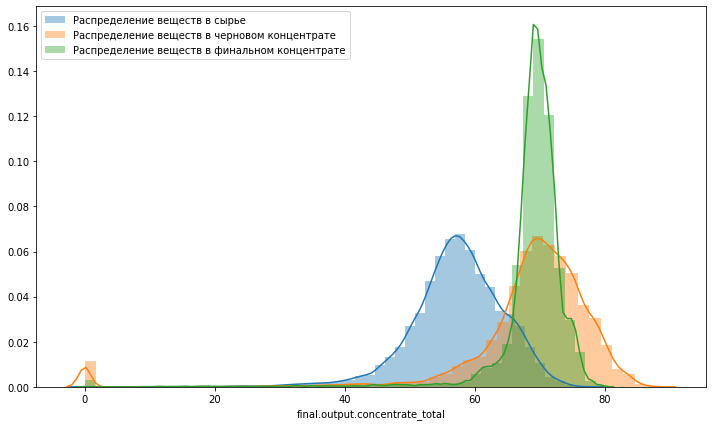

In [22]:
plt.figure(figsize=(12,7))
sns.distplot(data_full['rougher.input.concentrate_total'],  label='Распределение веществ в сырье')
sns.distplot(data_full['rougher.output.concentrate_total'], label='Распределение веществ в черновом концентрате')
sns.distplot(data_full['final.output.concentrate_total'], label='Распределение веществ в финальном концентрате')
plt.legend()
plt.show()

The distribution of substances in the final concentrate narrows.

The graph of concentration of substances revealed zero values. It is worth clarifying with the developers what is the reason for it, for the purpose of the project, we will remove this data from the datasets.

In [23]:
data_full = data_full[(data_full['rougher.input.concentrate_total'] > 0) & 
                      (data_full['rougher.output.concentrate_total'] > 0) &
                      (data_full['final.output.concentrate_total'] > 0)]

data_test = data_test[data_test.index.isin(data_full.index)]
data_train_new = data_train_new[data_train_new.index.isin(data_full.index)]

In [24]:
data_test.shape

(5154, 54)

In [25]:
data_train_new.shape

(13795, 54)

### Conclusion

In this part:

+ the concentration of gold, silver and lead at different stages of purification was analyzed, it turned out that the concentration of these metals behaves differently: gold - increases, silver - decreases, lead - mostly remains at the level of the first stage of purification
+ it was revealed that the distribution of raw material granule sizes in the test and training sample coincides
+ the concentration of all substances in different stages has been studied
+ zero values in the total concentration of substances were removed from the data sets

## Model

### Createb a function to calculate the final sMAPE.

In [26]:
def smape(target,predict):
    error = abs(target - predict)
    scale = (abs(target) + abs(predict)) / 2 
    return (error / scale).mean() 

def smape_result(smape_rough, smaper_final):
    smape_result = 0.25 * smape_rough + 0.75 * smaper_final             
    return smape_result

### Train different models and evaluate their quality by cross-validation. Choose the best model and test it on a test sample. Describe the conclusions.

Select datasets with target features and datasets with features in the training and test samples.


In [27]:
#Тестовая выборка
test_rough = data_test['rougher.output.recovery']
test_final = data_test['final.output.recovery']
features_test = data_test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)


In [28]:
#Обучающая выборка 
train_rough = data_train_new['rougher.output.recovery']
train_final = data_train_new['final.output.recovery']
features_train = data_train_new.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)


Create a formula for training different models and evaluating their quality using cross-validation.

In [29]:
models = [DecisionTreeRegressor(random_state = 12345), 
          RandomForestRegressor(random_state = 12345), 
          LinearRegression()]

In [30]:
def cross_val(model):
    
    my_scorer = make_scorer(smape, greater_is_better=False)
    
    cross_val_score_rougher = cross_val_score(model, features_train, train_rough, cv=5, scoring=my_scorer).mean()
    cross_val_score_final = cross_val_score(model, features_train, train_final, cv=5, scoring=my_scorer).mean()
    return cross_val_score_rougher, cross_val_score_final

for model in models:
    print(model.__class__.__name__,':', cross_val(model))

DecisionTreeRegressor : (-0.09533814866411697, -0.15919290828357152)
RandomForestRegressor : (-0.07115735310615308, -0.10945679862142714)
LinearRegression : (-0.07267806730900336, -0.10990200515157958)


We will proceed with a Linear Regression model, test it on a test sample and compare the quality indicator with the Dummy model.

In [31]:
model = LinearRegression()

model.fit(features_train, train_rough)
predictions_rough = model.predict(features_test)

model.fit(features_train, train_final)
predictions_final = model.predict(features_test)

smape_rough = smape(test_rough,predictions_rough)
smape_final = smape(test_final,predictions_final)
smape_model = smape_result(smape_rough, smape_final)
print('{:.2%}'.format(smape_model))

7.59%


In [32]:
dummy_model = DummyRegressor(strategy='mean')

dummy_model.fit(features_train, train_rough)
predictions_r_dummy = dummy_model.predict(features_test)

dummy_model.fit(features_train, train_final)
predictions_f_dummy = dummy_model.predict(features_test)

smape_dummy_rough = smape(test_rough,predictions_r_dummy)
smape_dummy_final = smape(test_final,predictions_f_dummy)
smape_dummy = smape_result(smape_dummy_rough, smape_dummy_final)
print('{:.2%}'.format(smape_dummy_final))

8.56%


### Conclusion

Cross-validation showed similar results for Linear Regression and Random Forest models, and a Linear regression model was chosen for further testing.

The value of the sMAPE for the Linear Regression model is 7.59%, and for the Dummy model with the "mean" strategy is 8.56%, which means that the model predicts better than a simple model. However, for real-world conditions, it might be useful to consider other models/clarify information about null values that have been removed from the dataset to improve the accuracy of the model prediction.